In [88]:
import numpy as np
import networkx as nx
from edge_fetch import edge_terrier
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from featureAnalysis import featureSelection
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize

In [89]:
##### Functions ######

##### Features ######
def getEigenVectorCentralityFeatures(graphList, numFeatures):
    # Eigen vector centrality is calculated using the sklearn function
    # The numFeatures chosen are selected based on the largest values
    # Largest values is determined by averaging the values for a node across all subjects
    # The numFeatures highest averages are used to select the features
    featureObj = featureSelection(graphList[0])
    X = featureObj.eigenvectorCentrality(numFeatures)
    mat = np.matrix(X, dtype = float)
    with open('outfileMat_HBN.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")
    return mat
    
def getKHOPFeatures(graphList, numFeatures):
    # Khop values are calculated using the networkx function
    # The values are calculated for 1 hop and 2 hops for each node
    # The numFeatures chosen are selected based on the highest variance values
    featureObj = featureSelection(graphList[0])
    X = featureObj.getKhopFeatMat(numFeatures)
    mat = np.matrix(X, dtype = float)
    with open('outfileMat.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")
    return mat

###### Plotting #####
    
def graph2D(mat):
    fig = plt.figure()
    plt.plot(mat[:,0], mat[:,1],'ro')
    fig.suptitle("Visualization of Clustered HBN Data (dwi)", fontsize=20)
    plt.xlabel("Feature 1", fontsize=18)
    plt.ylabel("Feature 2", fontsize=18)
def graph3D(mat):
    fig = plt.figure()
    ax = Axes3D(fig)
    x = mat[:,0]
    y = mat[:,1]
    z = mat[:,2]
    c1 = ax.scatter(x,y,z,marker='x')
    fig.suptitle("Visualization of Clustered HBN Data (dwi)", fontsize=20)
    ax.set_xlabel("Feature 1", fontsize=18)
    ax.set_ylabel("Feature 2", fontsize=18)
    ax.set_zlabel("Feature 3", fontsize=18)
    
def graph2DLabels(mat, labels):
    fig = plt.figure(3, figsize=(10, 10))
    ax = plt.Axes(fig, rect=[0, 0, .5, .5])
    z = list(labels)
    N = len(mat[:,1])
    x = [mat[:,0]]
    y = [mat[:,1]]
    #colors = ["r","k","y","m","dimgrey","b","yellow","palevioletred","cyan","lightgray","orange","lime","slateblue","pink","peru","cornflowerblue","saddlebrown","mediumspringgreen","thistle","lightcoral","slategrey","darkolivegreen","darkorchid","darkblue","brown","indianred","lightpink","paleturquoise","yellowgreen","tan"]
    cmap = matplotlib.cm.get_cmap('plasma')
    normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]
    colors = colors[0:numLabels]
    plt.scatter(x, y, color = colors)
    plt.title("HBN Eigenvector Centrality - \nJHU Directory all dwi samples")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
def graph3DLabels(mat, labels):
    fig = plt.figure(4, figsize=(10, 10))
    ax = Axes3D(fig, rect=[0, 0, .5, .5], elev=40, azim=150)
    ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c= labels, cmap = "plasma")
    ax.set_title('HBN Eigenvector Centrality - \nJHU Directory all dwi samples')
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
##### Clustering ######
def AffinityPropagationClustering(inputMat, dampInit = .4, dampInc = .1, preferenceInit = 0, preferenceInc = .05):
    maxDamp = 0
    maxPre = 0
    maxSil = 0
    pre = preferenceInit
    while pre < 1:
        #vary the preference value
        pre = pre + preferenceInc
        damp = dampInit
        while damp + dampInc <= .95:
            #vary the damping value
            damp = damp + dampInc
            af = AffinityPropagation(damping = damp, preference = pre, affinity="precomputed").fit(inputMat)
            cluster_centers_indices = af.cluster_centers_indices_
            labels = af.labels_
            n_clusters = len(cluster_centers_indices)
            if n_clusters <= len(inputMat) - 1:
                ss = silhouette_score(inputMat, labels)
                print('|Preference |% 1.2f' % pre, "| Damping | % 1.1f" % damp,"| Clusters | ", n_clusters, "| Silhouette | % 1.3f" % ss, "|")
            #capture max preproc and damping
                if (ss > maxSil):
                    maxDamp = damp
                    maxPre = pre
                    maxSil = ss
    print("Best Damping Value:", maxDamp, "Best Preference Value:", maxPre)
    return maxDamp, maxPre, maxSil

def MiniBatchKMeansClustering(inputMat, clustInit = 1, clustInc = 1, batchSizeInit = 40, batchSizeInc = 10):
    maxClusters = 0
    maxSize = 0
    maxSil = 0
    clust = clustInit
    while clust < (len(inputMat) * 3 / 4):
        #vary the cluster number
        batchSize = batchSizeInit
        clust = clust + clustInc
        while batchSize < len(inputMat):
            #vary the batch size
            batchSize = batchSize + batchSizeInc
            mb = MiniBatchKMeans(n_clusters = clust, batch_size = batchSize).fit(inputMat)
            cluster_centers_ = mb.cluster_centers_
            labels = mb.labels_
            ss = silhouette_score(inputMat, labels)
            print('|BatchSize |% 1.2f' %  batchSize, "| Clusters | % 1.1f" % clust, "| Silhouette | % 1.3f" % ss, "|")

            #capture best clusters and batchsize
            if (ss > maxSil):
                maxClusters = clust
                maxSize = batchSize
                maxSil = ss
    print("Best Batch Size:", maxSize, "Best Num Clusters:", maxClusters)
    return maxClusters, maxSize, maxSil

In [90]:
##### Load Edgelists #####

# Initialize edgelist collector object
graph_collector = edge_terrier('/Users/paigefrank/Library/Python/3.6/bin/aws', 1 , filepath='hbn/derivatives/graphs/JHU/')
# Make a generator that yields all edgelists in filepath
filelist = graph_collector.convert_edgelist_all()
# Get a list of just the network x objects
graphList = graph_collector.getGraphs(filelist)

sub-NDARDX770PJK_acq-64dir_dwi_JHU.edgelist is empty.


In [91]:
##### Output feature matrix to a file ####
numFeatures = 100
#mat = getKHOPFeatures(graphList, numFeatures)
mat = getEigenVectorCentralityFeatures(graphList, numFeatures)


Feature matrix of shape (97, 48) outputted. Run Urerf in R now.


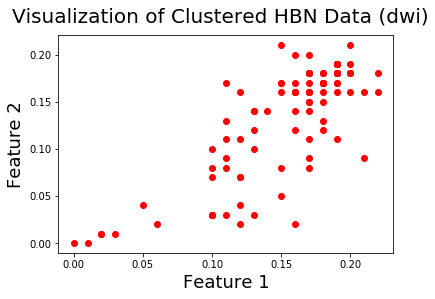

In [79]:
##### Graph the data if the features are less than 3 dimensions #####
if numFeatures == 2:
    graph2D(mat)
if numFeatures == 3:
    graph3D(mat)


In [58]:
##### Load Urerf Similarity matrix from file ######

matrix = open('outfileSimMat.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)

In [59]:
##### CLUSTER ######
print("AFFINITY PROPAGATION")
maxDamp, maxPre, maxSil = AffinityPropagationClustering(inputMat,.4,.1, 0, .05)
print("MINI BATCH K MEANS")
maxClusters, maxSize, maxSil = MiniBatchKMeansClustering(mat, 1, 1, 40, 10)

AFFINITY PROPAGATION
|Preference | 0.05 | Damping |  0.5 | Clusters |  23 | Silhouette |  0.388 |
|Preference | 0.05 | Damping |  0.6 | Clusters |  23 | Silhouette |  0.388 |
|Preference | 0.05 | Damping |  0.7 | Clusters |  23 | Silhouette |  0.388 |
|Preference | 0.05 | Damping |  0.8 | Clusters |  25 | Silhouette |  0.386 |
|Preference | 0.05 | Damping |  0.9 | Clusters |  27 | Silhouette |  0.314 |
|Preference | 0.10 | Damping |  0.5 | Clusters |  24 | Silhouette |  0.422 |
|Preference | 0.10 | Damping |  0.6 | Clusters |  24 | Silhouette |  0.422 |
|Preference | 0.10 | Damping |  0.7 | Clusters |  24 | Silhouette |  0.422 |
|Preference | 0.10 | Damping |  0.8 | Clusters |  24 | Silhouette |  0.422 |
|Preference | 0.10 | Damping |  0.9 | Clusters |  18 | Silhouette |  0.305 |
|Preference | 0.15 | Damping |  0.5 | Clusters |  26 | Silhouette |  0.424 |
|Preference | 0.15 | Damping |  0.6 | Clusters |  26 | Silhouette |  0.424 |
|Preference | 0.15 | Damping |  0.7 | Clusters |  26 | 

|BatchSize | 80.00 | Clusters |  4.0 | Silhouette |  0.423 |
|BatchSize | 90.00 | Clusters |  4.0 | Silhouette |  0.423 |
|BatchSize | 100.00 | Clusters |  4.0 | Silhouette |  0.423 |
|BatchSize | 50.00 | Clusters |  5.0 | Silhouette |  0.448 |
|BatchSize | 60.00 | Clusters |  5.0 | Silhouette |  0.262 |
|BatchSize | 70.00 | Clusters |  5.0 | Silhouette |  0.306 |
|BatchSize | 80.00 | Clusters |  5.0 | Silhouette |  0.308 |
|BatchSize | 90.00 | Clusters |  5.0 | Silhouette |  0.294 |
|BatchSize | 100.00 | Clusters |  5.0 | Silhouette |  0.291 |
|BatchSize | 50.00 | Clusters |  6.0 | Silhouette |  0.405 |
|BatchSize | 60.00 | Clusters |  6.0 | Silhouette |  0.346 |
|BatchSize | 70.00 | Clusters |  6.0 | Silhouette |  0.270 |
|BatchSize | 80.00 | Clusters |  6.0 | Silhouette |  0.443 |
|BatchSize | 90.00 | Clusters |  6.0 | Silhouette |  0.292 |
|BatchSize | 100.00 | Clusters |  6.0 | Silhouette |  0.410 |
|BatchSize | 50.00 | Clusters |  7.0 | Silhouette |  0.292 |
|BatchSize | 60.00 | 

|BatchSize | 100.00 | Clusters |  26.0 | Silhouette |  0.295 |
|BatchSize | 50.00 | Clusters |  27.0 | Silhouette |  0.298 |
|BatchSize | 60.00 | Clusters |  27.0 | Silhouette |  0.294 |
|BatchSize | 70.00 | Clusters |  27.0 | Silhouette |  0.289 |
|BatchSize | 80.00 | Clusters |  27.0 | Silhouette |  0.298 |
|BatchSize | 90.00 | Clusters |  27.0 | Silhouette |  0.311 |
|BatchSize | 100.00 | Clusters |  27.0 | Silhouette |  0.301 |
|BatchSize | 50.00 | Clusters |  28.0 | Silhouette |  0.300 |
|BatchSize | 60.00 | Clusters |  28.0 | Silhouette |  0.289 |
|BatchSize | 70.00 | Clusters |  28.0 | Silhouette |  0.293 |
|BatchSize | 80.00 | Clusters |  28.0 | Silhouette |  0.286 |
|BatchSize | 90.00 | Clusters |  28.0 | Silhouette |  0.266 |
|BatchSize | 100.00 | Clusters |  28.0 | Silhouette |  0.312 |
|BatchSize | 50.00 | Clusters |  29.0 | Silhouette |  0.280 |
|BatchSize | 60.00 | Clusters |  29.0 | Silhouette |  0.291 |
|BatchSize | 70.00 | Clusters |  29.0 | Silhouette |  0.288 |
|Batc

|BatchSize | 100.00 | Clusters |  48.0 | Silhouette |  0.214 |
|BatchSize | 50.00 | Clusters |  49.0 | Silhouette |  0.229 |
|BatchSize | 60.00 | Clusters |  49.0 | Silhouette |  0.235 |
|BatchSize | 70.00 | Clusters |  49.0 | Silhouette |  0.238 |
|BatchSize | 80.00 | Clusters |  49.0 | Silhouette |  0.228 |
|BatchSize | 90.00 | Clusters |  49.0 | Silhouette |  0.212 |
|BatchSize | 100.00 | Clusters |  49.0 | Silhouette |  0.213 |
|BatchSize | 50.00 | Clusters |  50.0 | Silhouette |  0.212 |
|BatchSize | 60.00 | Clusters |  50.0 | Silhouette |  0.241 |
|BatchSize | 70.00 | Clusters |  50.0 | Silhouette |  0.203 |
|BatchSize | 80.00 | Clusters |  50.0 | Silhouette |  0.237 |
|BatchSize | 90.00 | Clusters |  50.0 | Silhouette |  0.232 |
|BatchSize | 100.00 | Clusters |  50.0 | Silhouette |  0.242 |
|BatchSize | 50.00 | Clusters |  51.0 | Silhouette |  0.192 |
|BatchSize | 60.00 | Clusters |  51.0 | Silhouette |  0.257 |
|BatchSize | 70.00 | Clusters |  51.0 | Silhouette |  0.240 |
|Batc

|BatchSize | 100.00 | Clusters |  70.0 | Silhouette |  0.234 |
|BatchSize | 50.00 | Clusters |  71.0 | Silhouette |  0.222 |
|BatchSize | 60.00 | Clusters |  71.0 | Silhouette |  0.174 |
|BatchSize | 70.00 | Clusters |  71.0 | Silhouette |  0.210 |
|BatchSize | 80.00 | Clusters |  71.0 | Silhouette |  0.222 |
|BatchSize | 90.00 | Clusters |  71.0 | Silhouette |  0.219 |
|BatchSize | 100.00 | Clusters |  71.0 | Silhouette |  0.230 |
|BatchSize | 50.00 | Clusters |  72.0 | Silhouette |  0.201 |
|BatchSize | 60.00 | Clusters |  72.0 | Silhouette |  0.212 |
|BatchSize | 70.00 | Clusters |  72.0 | Silhouette |  0.193 |
|BatchSize | 80.00 | Clusters |  72.0 | Silhouette |  0.233 |
|BatchSize | 90.00 | Clusters |  72.0 | Silhouette |  0.235 |
|BatchSize | 100.00 | Clusters |  72.0 | Silhouette |  0.215 |
|BatchSize | 50.00 | Clusters |  73.0 | Silhouette |  0.224 |
|BatchSize | 60.00 | Clusters |  73.0 | Silhouette |  0.202 |
|BatchSize | 70.00 | Clusters |  73.0 | Silhouette |  0.213 |
|Batc

In [60]:
##### isolate best clustering output and create a sorted similarity matrix ####

# cluster using the best affinity propagation output
af = AffinityPropagation(damping = maxDamp, preference = maxPre,affinity="precomputed").fit(inputMat)
cluster_centers_indices = af.cluster_centers_indices_
labels_best_af = af.labels_
n_clusters_af = len(cluster_centers_indices)


# cluster using the best mini batch k means output
mb = MiniBatchKMeans(n_clusters= maxClusters, batch_size = maxSize).fit(mat)
cluster_centers_ = mb.cluster_centers_
labels_best_mb = mb.labels_
n_clusters_mb = len(cluster_centers_)

##### Sort the Urerf similarity matrix based on affinity propagation cluster #####

#create a dictionary of labels and subjects
nodeDict = dict(enumerate(labels_best_af))
#sort the subjects so that they are grouped by cluster label
s = sorted(nodeDict, key=nodeDict.get)
#create a sorted similarity matrix
sortedSimMat = np.empty((len(s), len(s)))
for i in range(0, len(s)):
    node = s[i]
    for j in range(0,len(s)):
        node2 = s[j]
        sortedSimMat[i][j] = inputMat[node, node2]

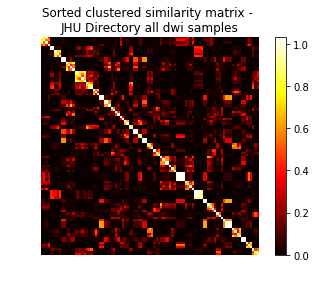

In [61]:
###### create a heat map of the sorted similarity matrix ######
plt.figure(1)
im = plt.imshow(sortedSimMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Graphs')
plt.ylabel('Graphs')
plt.title("Sorted clustered similarity matrix - \nJHU Directory all dwi samples")
plt.axis('off')
plt.show()

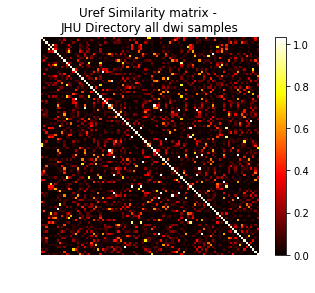

In [62]:
###### create a heat map of the unsorted similarity matrix ######
plt.figure(2)
im = plt.imshow(inputMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Graphs')
plt.ylabel('Graphs')
plt.title("Uref Similarity matrix - \nJHU Directory all dwi samples")
plt.axis('off')
plt.show()

AFFINITY PROPAGATION
Number of Clusters =  36


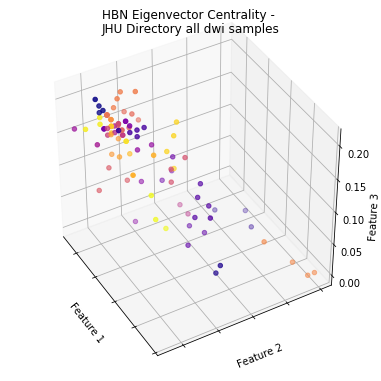

In [67]:
###### Create a plot of the clusters color-coded as such ######
print('AFFINITY PROPAGATION')
if (numFeatures ==2):
    graph2DLabels(mat,labels_best_af)
if (numFeatures ==3):
    graph3DLabels(mat,labels_best_af)
print("Number of Clusters = ", n_clusters_af)

MINI BATCH K MEANS
Number of Clusters =  2


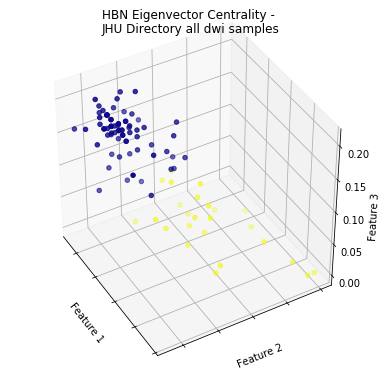

In [75]:
###### Create a plot of the clusters color-coded as such ######
print('MINI BATCH K MEANS')
if (numFeatures ==2):
    graph2DLabels(mat,labels_best_mb)

if (numFeatures ==3):
    graph3DLabels(mat,labels_best_mb)
print("Number of Clusters = ", n_clusters_mb)